# Proyecto Final Machine Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

sns.set_style("whitegrid")

## Limpieza de datos

In [2]:
''' Se cargan los datos '''
df = pd.read_csv('AirQualityUCI.csv', sep=';')
df.drop(columns=['Unnamed: 15','Unnamed: 16'], inplace=True)
df.dropna(inplace=True)

''' Se cambia al formato deseado '''
cols = [col  for col in df.columns if df[col].dtype == 'O' and col != 'Time']
df['Time'] = df['Time'].str.replace('.',':')
df[cols] = df[cols].replace(',','.',regex = True)
df[df.columns[2:]] = df[df.columns[2:]].astype(float)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Time'] = pd.to_timedelta(df['Time'], errors = 'ignore')

''' Indice como fecha y los valores -200 se pasan a nan'''
df.index = df['Date'] + df['Time']
df.drop(['Date','Time'],axis=1,inplace=True)
df = df.replace(-200,np.nan)
df.index.name = 'Fecha'
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Fecha,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


## Datos Faltantes

In [3]:
import missingno as msno

In [4]:
""" Cuantos nan hay por columna """
df.isna().sum()

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [5]:
''' Se quitan las columnas con demasiados nan '''
df.drop(['NMHC(GT)'],axis=1,inplace=True)

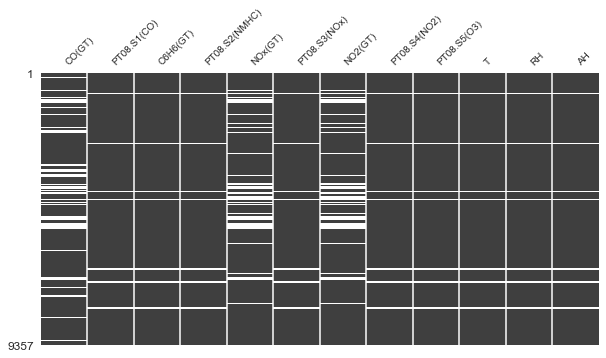

In [6]:
''' Distribucion de los nan '''
fig =msno.matrix(df[df.isnull().sum().index], 
                 labels=True,
                 sparkline=False, figsize=(10,5), fontsize=10)
fig_copy = fig.get_figure()
# fig_copy.suptitle('Distribucion de información faltante', fontsize=25)
plt.show()

In [7]:
# import plotly.express as px
import plotly.graph_objects as go

def plot_tiempo(columna):
    fig = go.Figure([go.Scatter(x=df.index, y=df[columna])])
    fig.show()
def plot_cols(col1,col2):
    df_nan = df[[col1,col2]].dropna()
    plt.figure(figsize=(15,7))
    plt.plot(df_nan.values.T[0],df_nan.values.T[1],'o')
    plt.xlabel(col1,fontsize=15)
    plt.ylabel(col2,fontsize=15)
    plt.title('Comparacion '+col2+' con '+col1,fontsize=15)
# def plot_fit(col1,col2,modelo):
#     df_nan = df[[col1,col2]].dropna()
#     plt.figure(figsize=(15,7))
#     plt.plot(df_nan.values.T[1],df_nan.values.T[0],'o')
#     plt.plot(df_nan.values.T[1],)
#     plt.xlabel(col1,fontsize=15)
#     plt.ylabel(col2,fontsize=15)
#     plt.title('Comparacion '+col2+' con '+col1,fontsize=15)

Se usara la relacion entre las columnas GT y PT para rellenar los datos faltantes (siempre que se pueda).

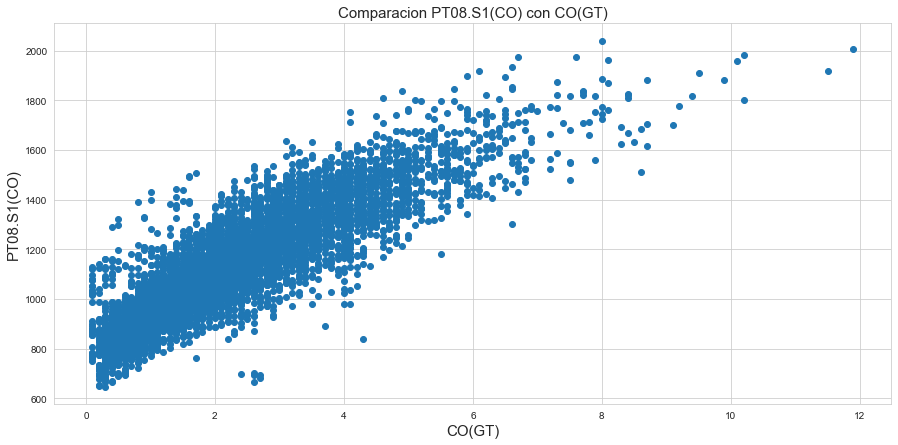

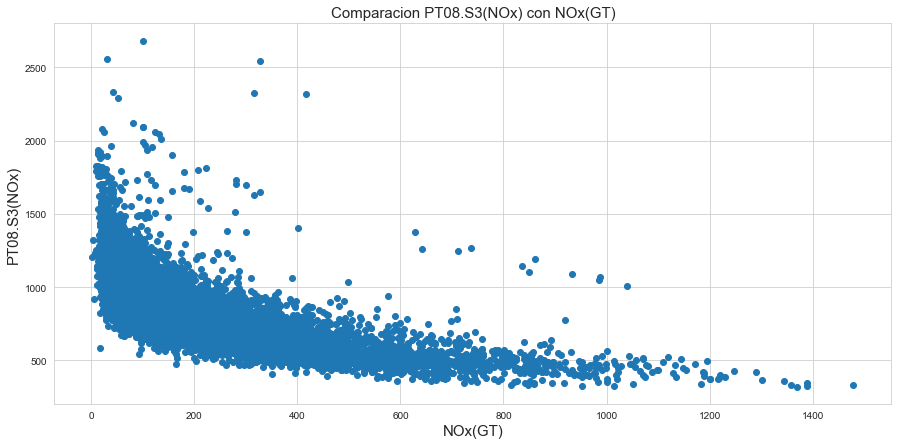

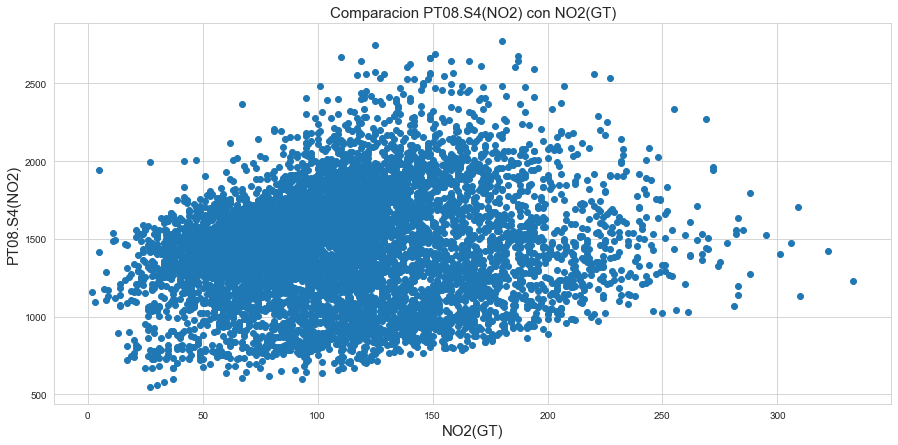

In [8]:
plot_cols('CO(GT)','PT08.S1(CO)')
plot_cols('NOx(GT)','PT08.S3(NOx)')
plot_cols('NO2(GT)','PT08.S4(NO2)')

Al observar los graficos se ve que para las primeras dos comparaciones es favorable ajustar una curva a los datos.

In [9]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

In [10]:
def Regresion_Lineal(columnas):
    df_nan = df[columnas].dropna() 
    X = df_nan[[columnas[0]]].values
    y = df_nan[columnas[1]].values
    regr = linear_model.RidgeCV().fit(X,y)
    return regr

def curve(x,a,b,c):
    return a*np.exp(-b*x)+c

def Regresion_Nolineal(columnas):
    df_nan = df[columnas].dropna() 
    X = df_nan[columnas[0]].values
    y = df_nan[columnas[1]].values
    regr,cov = curve_fit(curve,X,y)
    return regr

In [11]:
modeloCO = Regresion_Lineal(['CO(GT)','PT08.S1(CO)'])
modeloNOx = Regresion_Nolineal(['NOx(GT)','PT08.S3(NOx)'])

In [12]:
def plot_fit(col1,col2,modelo):
    df_nan = df[[col1,col2]].dropna()
    X = df_nan.values[:,0].reshape(-1,1)
    try:
        y_pred = modelo.predict(X)
        tipo = ''
    except:
        y_pred = curve(X,*modelo)
        tipo = '.'
    y = df_nan.values[:,1]
    plt.figure(figsize=(15,7))
    plt.plot(X,y,'o')
    plt.plot(X,y_pred,tipo)
    plt.xlabel(col1,fontsize=15)
    plt.ylabel(col2,fontsize=15)
    plt.title('Ajuste '+col2+' con respecto a '+col1,fontsize=15)
    plt.show()

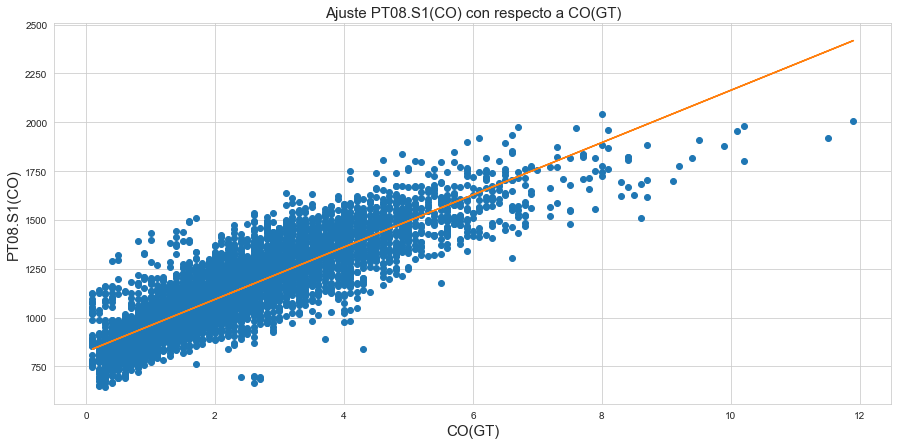

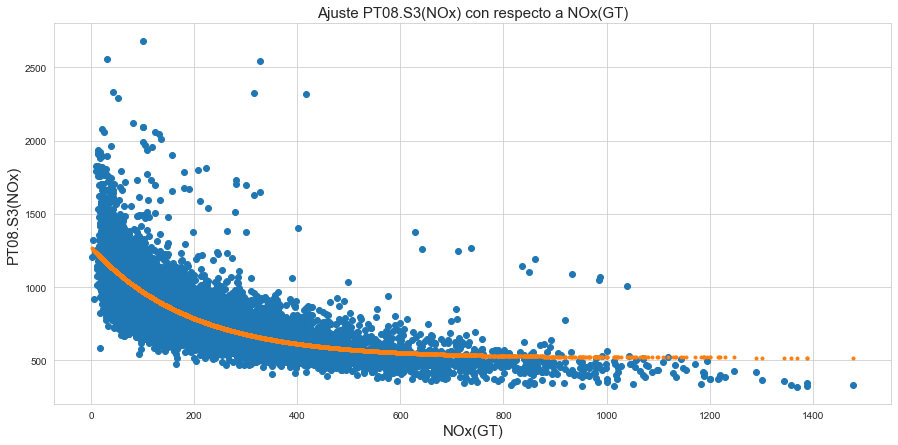

In [13]:
plot_fit('CO(GT)','PT08.S1(CO)',modeloCO)
plot_fit('NOx(GT)','PT08.S3(NOx)',modeloNOx)

## Distribucion de los datos

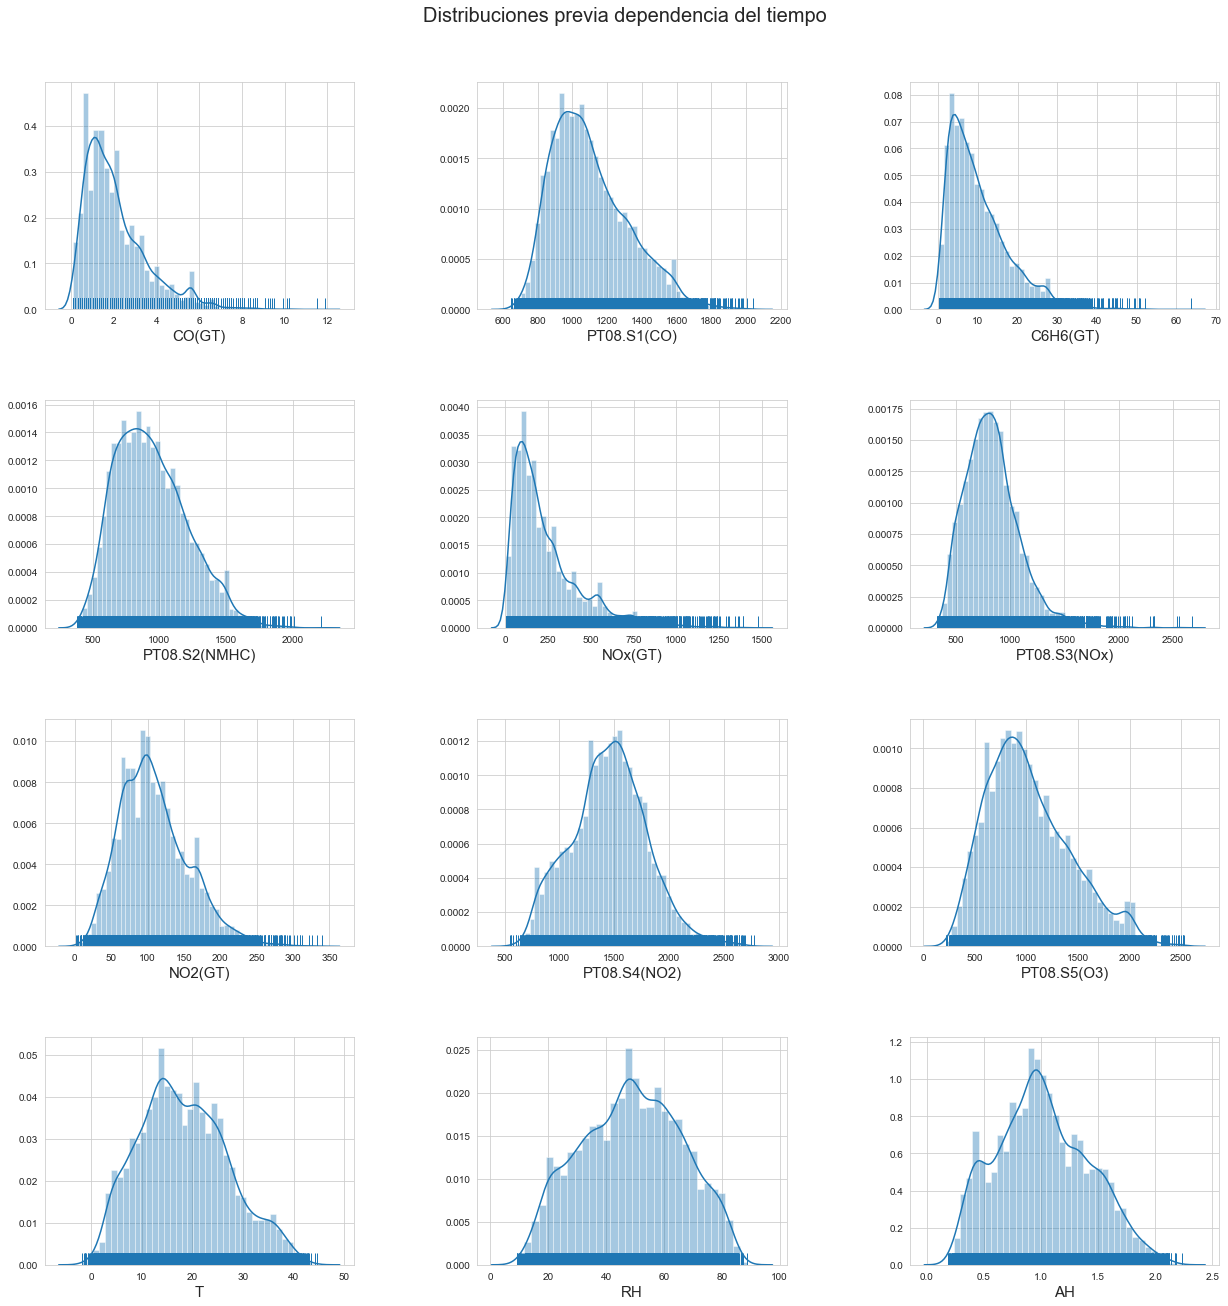

In [20]:
# Vista previa de la distribución de datos sin considerar la dependencia temporal
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[17, 17])
fig.tight_layout()

# list(map(lambda a : a.remove(), ax[-1,1:]))
fig.suptitle('Distribuciones previa dependencia del tiempo',
             fontsize=20,
             x=0.5,
             y=1.05)

for axis, col in zip(ax.flatten(), df.columns[:]):
    try :
        sns.distplot(df[col], ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[col], ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [15]:
antes = pd.concat([df.mean(axis=0).to_frame('mean'),df.var(axis=0).to_frame('var')],axis=1)
antes.drop([x for x in antes.index if 'GT' in x],axis=0,inplace=True)
antes

,mean,var
PT08.S1(CO),1099.833166,47123.742575
PT08.S2(NMHC),939.153376,71199.011290
PT08.S3(NOx),835.493605,65955.135860
PT08.S4(NO2),1456.264598,119859.143884
PT08.S5(O3),1022.906128,158789.727561
T,18.317829,78.006268
RH,49.234201,299.874765
AH,1.025530,0.163065


In [16]:
for x in df.columns:
    df[x].fillna(method='ffill', inplace=True)

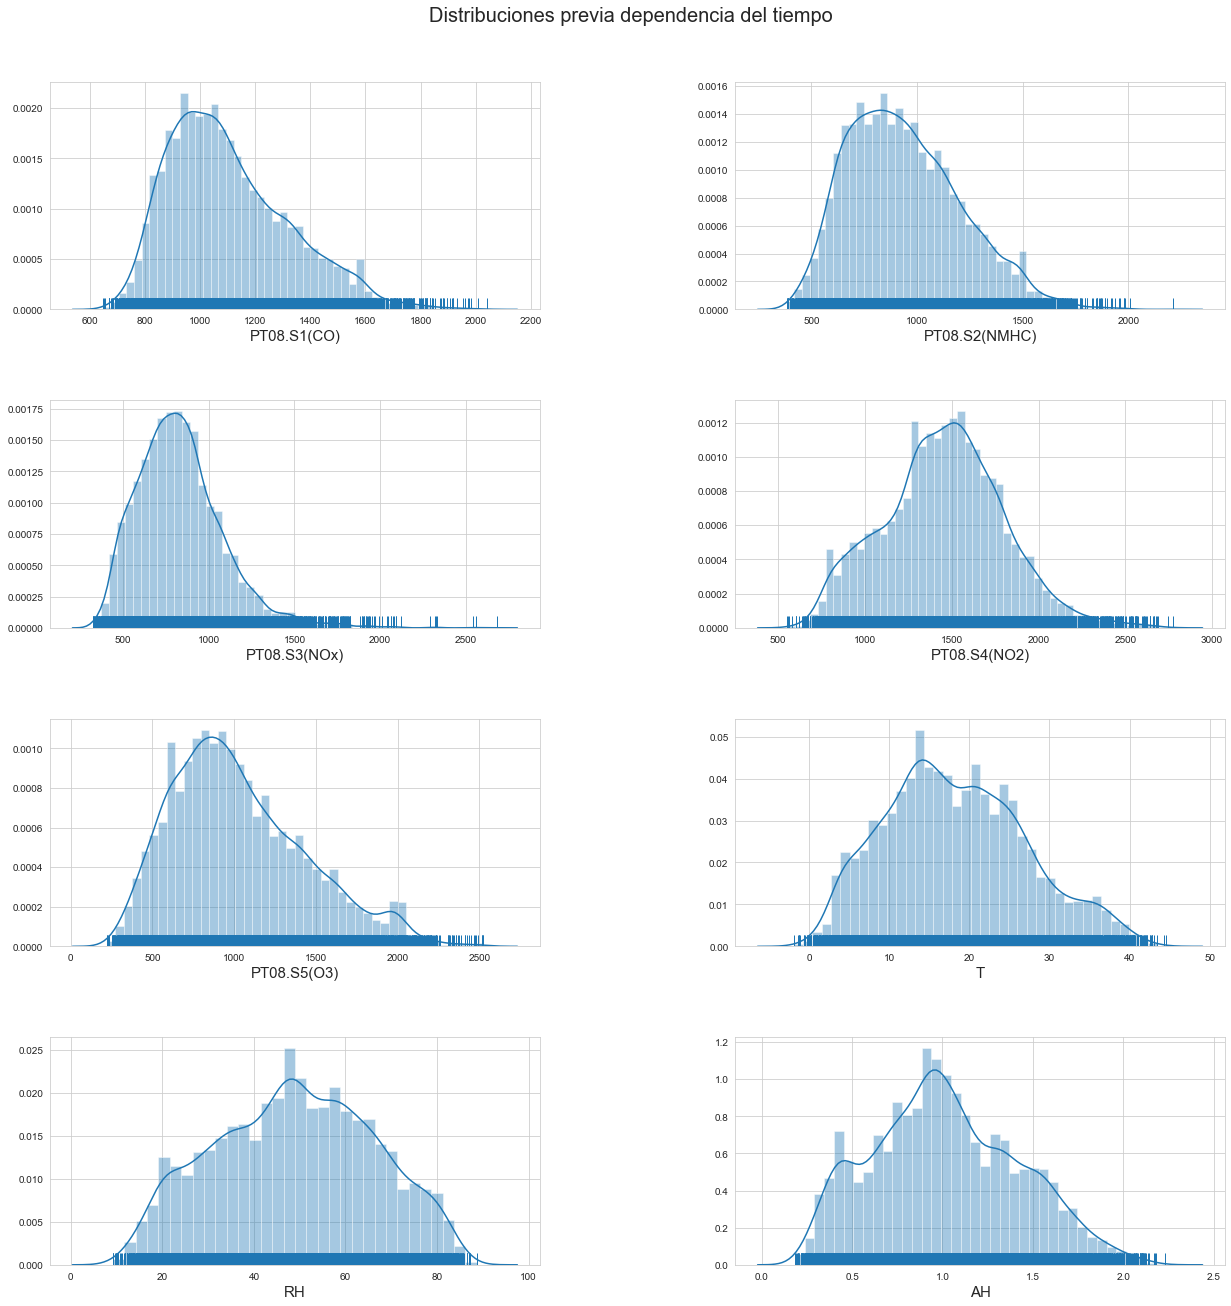

In [17]:
# Vista previa de la distribución de datos sin considerar la dependencia temporal
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[17, 17])
fig.tight_layout()

fig.suptitle('Distribuciones previa dependencia del tiempo',
             fontsize=20,
             x=0.5,
             y=1.05)

for axis, col in zip(ax.flatten(), [x for x in df.columns[:] if 'GT' not in x]):
    try :
        sns.distplot(df[col], ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[col], ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [18]:
despues = pd.concat([df.mean(axis=0).to_frame('mean despues'),df.var(axis=0).to_frame('var despues')],axis=1)
despues.drop([x for x in despues.index if 'GT' in x],axis=0,inplace = True)
comparacion = pd.concat([antes,despues],axis=1)
comparacion

,mean,var,mean despues,var despues
PT08.S1(CO),1099.833166,47123.742575,1102.730362,48218.934021
PT08.S2(NMHC),939.153376,71199.011290,942.548253,72674.114094
PT08.S3(NOx),835.493605,65955.135860,832.742225,65387.308919
PT08.S4(NO2),1456.264598,119859.143884,1453.014535,120710.442713
PT08.S5(O3),1022.906128,158789.727561,1030.511916,168852.582719
T,18.317829,78.006268,18.317356,77.825620
RH,49.234201,299.874765,48.817431,301.172626
AH,1.025530,0.163065,1.017382,0.163886


## Matraca prediccion

In [10]:
from pmdarima.arima import auto_arima # hay que instalar esta wea por sia: pip install pmdarima

In [11]:
def train_test_split(df,tamaño = 0.8):
    X_train = df[:int(df.shape[0]*(tamaño))]
    X_test = df[int(df.shape[0]*tamaño):]
    return X_train,X_test

In [12]:
X_train,X_test = train_test_split(df_nan)

In [15]:
def Modelo_auto_arima(df,columna):
    df_col1 = df[[columna]]
    model = auto_arima(df_col1, start_p=1, start_q=1,max_p=7, max_q=7,d=1, max_d=7
                               ,seasonal = True,trace=True,error_action='ignore',suppress_warnings=True, 
                               stepwise=True)
    return model

In [16]:
model = Modelo_auto_arima(X_test,'CO(GT)')

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4442.875, BIC=4465.012, Time=1.717 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4559.261, BIC=4570.330, Time=0.372 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=4485.679, BIC=4502.281, Time=0.178 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=4450.741, BIC=4467.344, Time=0.240 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=4557.263, BIC=4562.797, Time=0.061 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=4166.742, BIC=4194.413, Time=2.421 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=4390.110, BIC=4412.247, Time=0.259 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=4164.796, BIC=4198.001, Time=2.175 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=4355.337, BIC=4383.008, Time=0.462 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=4166.754, BIC=4205.494, Time=3.809 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercep

In [19]:
model

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1872
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -2076.398
Date:                Mon, 06 Jul 2020   AIC                           4164.796
Time:                        12:11:02   BIC                           4198.001
Sample:                             0   HQIC                          4177.029
                               - 1872                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7.269e-05      0.001     -0.098      0.922      -0.002       0.001
ar.L1          1.0641      0.022     49.060      0.000       1.022       1.107
ar.L2         -0.3982      0.029    -13.631      0.000      -0.455      -0.341
ar.L3          0.0488      0.023      2.081      0.037       0.003       0.095
ma.L1         -0.9647      0.008   -115.133      0.000      -0.981      -0.948
sigma2         0.5384      0.012     46.412      0.000       0.516       0.561
===================================================================================
Ljung-Box (Q):                      372.94   Jarque-Bera (JB):              1067.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.63
Prob(H) (two-sided):                  0.45   Kurtosis:                         6.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""